In [29]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)



In [30]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [31]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

path_to_chain = dataset.get_class_files("chainsaw")
audio1,sr = AudioUtil.open(path_to_chain[0])
print("Audio shape: ", audio1)
# calculate the time that last the audio
print("Audio duration: ", len(audio1) / sr)

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [32]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [33]:
### TO RUN

# "Creation of the dataset"
# myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=5000/2-350, shift_pct=0)

# "Some attributes..."
# myds.nmel
# myds.duration
# myds.shift_pct
# myds.sr
# myds.data_aug
# myds.ncol

# # idx = 10
# # myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fire", idx])
# import time
# # time.sleep(2.5)
# idx = 2
# myds.display(["fire", idx])


"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=2500, shift_pct=0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol


# for i in range(80):
#     myds.display(["fire", i])
#     plt.show()
#     plt.close()



49

In [34]:
# ds_1s_delayed = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=1004, shift_pct=0)
# # a = ds_1s_delayed["fireworks",18]
# ds_1s_delayed.display(["fireworks",18])
# a = ds_1s_delayed["fireworks",18]
# ## transform the shape in a n*20
# a =a.reshape(-1,20)
# print(a.shape)
# print(a)

# ds_1s_delayed = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=1004, shift_pct=0.0502)
# # a = ds_1s_delayed["fireworks",18]
# ds_1s_delayed.display(["fireworks",18])
# a = ds_1s_delayed["fireworks",18]
# ## transform the shape in a n*20
# a =a.reshape(-1,20)
# print(a.shape)
# print(a)


In [35]:
import numpy as np

# --- Paramètres ---
train_pct = 0.7
featveclen = len(myds["fire", 0])  # taille d’un vecteur de caractéristiques
nitems = len(myds)
naudio = dataset.naudio  # dict: nombre d’audios par classe

nclass = dataset.nclass  # nombre total de classes
data_aug_factor = 1
classnames = list(naudio.keys())  # assure que classnames est bien défini
print("naudio: ", naudio)
naudio_sum = sum(naudio.values())  # total d’échantillons toutes classes confondues

# ID des classes (répétés selon le nombre d’audios par classe)
class_ids_aug = np.concatenate([
    np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames
])

# --- Préparation des offsets cumulatifs pour les index globaux ---
offsets = {}
current_offset = 0
for cname in classnames:
    offsets[cname] = current_offset
    current_offset += naudio[cname]

# --- Allocation de la matrice X ---
X = np.zeros((data_aug_factor * naudio_sum, featveclen))

# --- Remplissage de X avec les vecteurs de caractéristiques ---
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]

            global_idx = s * naudio_sum + offsets[classname] + idx
            X[global_idx, :] = featvec

            # Debug
            if global_idx == 225:
                print("ici------------------------------------------------")
            print(f"Index: {global_idx}, Class Name: {classname}")

# --- Étiquettes ---
y = class_ids_aug.copy()
classnames = np.unique(y)

np.save(fm_dir + "feature_matrix_2D.npy", X)
np.save(fm_dir + "labels_2D.npy", y)

# --- Affichage de résumé ---
print("-" * 20)
for idx, elem in enumerate(X):
    mean_value = np.mean(elem)
    class_name = y[idx]
    print(f"Index: {idx}, Class Name: {class_name}, Mean Value: {mean_value}")
    
X = np.load(fm_dir + "feature_matrix_2D.npy")
y = np.load(fm_dir + "labels_2D.npy")

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")




naudio:  {'chainsaw': 80, 'fire': 78, 'fireworks': 71, 'gun': 40}
Index: 0, Class Name: chainsaw
Index: 1, Class Name: chainsaw
Index: 2, Class Name: chainsaw
Index: 3, Class Name: chainsaw
Index: 4, Class Name: chainsaw
Index: 5, Class Name: chainsaw
Index: 6, Class Name: chainsaw
Index: 7, Class Name: chainsaw
Index: 8, Class Name: chainsaw
Index: 9, Class Name: chainsaw
Index: 10, Class Name: chainsaw
Index: 11, Class Name: chainsaw
Index: 12, Class Name: chainsaw
Index: 13, Class Name: chainsaw
Index: 14, Class Name: chainsaw
Index: 15, Class Name: chainsaw
Index: 16, Class Name: chainsaw
Index: 17, Class Name: chainsaw
Index: 18, Class Name: chainsaw
Index: 19, Class Name: chainsaw
Index: 20, Class Name: chainsaw
Index: 21, Class Name: chainsaw
Index: 22, Class Name: chainsaw
Index: 23, Class Name: chainsaw
Index: 24, Class Name: chainsaw
Index: 25, Class Name: chainsaw
Index: 26, Class Name: chainsaw
Index: 27, Class Name: chainsaw
Index: 28, Class Name: chainsaw
Index: 29, Class

In [36]:

import numpy as np

# Charger les données
X = np.load(fm_dir + "feature_matrix_2D.npy")  # Matrice des caractéristiques
y = np.load(fm_dir + "labels_2D.npy")          # Étiquettes associées

# Filtrer les indices correspondant à la classe "gun"
indices_classe_gun = np.where(y == "gun")[0]

# Initialiser une matrice pour stocker les melspectrogrammes modifiés de la classe "gun"
# Chaque melspectrogramme sera réduit à une taille de 20x20 (400 éléments)
X_modifie_gun = np.zeros((naudio["gun"], 400))

# Parcourir tous les indices des melspectrogrammes de la classe "gun"
for idx in indices_classe_gun:
    forme_originale = X[idx ].shape
    melspectrogramme = X[idx].reshape(-1, 49)

    # Garder uniquement les colonnes 3 à 23 (dimensions temporelles importantes)
    melspectrogramme_tronque = melspectrogramme[:, 3:23]

    X_modifie_gun[idx - indices_classe_gun[0]] = melspectrogramme_tronque.flatten()

    print(f"Index: {idx - indices_classe_gun[0]}, "
          f"Forme originale: {forme_originale}, "
          f"Forme tronquée: {melspectrogramme_tronque.shape}")
    
y_modifie_gun = np.array(["gun"] * X_modifie_gun.shape[0])

np.save( fm_dir + "labels_2D_gun_modified.npy", y_modifie_gun)
np.save( fm_dir + "feature_matrix_2D_gun_modified.npy", X_modifie_gun)
# # Filtrer les indices correspondant à la classe "gun"
# y_indices = np.where(y == "gun")[0]

# # Afficher les mél-spectrogrammes pour chaque son de la classe "gun"
# for idx in y_indices:
#     plt.figure(figsize=(2, 1))
#     plt.imshow(X_modifie_gun[idx-y_indices[0]].reshape(20, 20), cmap="jet", aspect="auto")
#     plt.colorbar(label="Amplitude")
#     plt.title(f"Mel Spectrogram of 'gun' at index {idx-y_indices[0]}")
#     plt.xlabel("Time")
#     plt.ylabel("Frequency")
#     plt.gca().invert_yaxis()
#     plt.show()
    



Index: 0, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 1, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 2, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 3, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 4, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 5, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 6, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 7, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 8, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 9, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 10, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 11, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 12, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 13, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 14, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 15, Forme originale: (980,), Forme tronquée: (20, 20)
Index: 16, Forme originale: (980,)

In [37]:
import numpy as np

# Charger les données
X = np.load(fm_dir + "feature_matrix_2D.npy")  # Matrice des caractéristiques
y = np.load(fm_dir + "labels_2D.npy")          # Étiquettes associées

# Classe concernée
classname = "chainsaw"

# Initialiser la matrice pour stocker les melspectrogrammes modifiés
X_modifie_chainsaw = np.zeros((naudio[classname] * 2, 400))

# Filtrer les indices correspondant à la classe "chainsaw"
indices_classe = np.where(y == classname)[0]

# Parcourir les indices de la classe "chainsaw"
for idx, global_idx in enumerate(indices_classe):
    # Reshape pour transformer le vecteur 1D en une matrice 2D (temps x mels)
    melspectrogramme = X[global_idx].reshape(-1, 49)

    # --- Extraction du premier melspectrogramme ---
    # Toujours commencer à l'indice 3 et prendre les dimensions 3 à 23
    premier_melspectrogramme = melspectrogramme[:, 3:23]

    # --- Extraction du second melspectrogramme ---
    # Calculer les amplitudes moyennes pour les 20 dernières dimensions temporelles
    amplitudes_moyennes = [
        np.mean(melspectrogramme[:, start:start + 20]) for start in range(29, 49 - 20 + 1)
    ]
    # Trouver l'indice de départ qui maximise l'amplitude
    indice_depart_second = 29 + np.argmax(amplitudes_moyennes)
    second_melspectrogramme = melspectrogramme[:, indice_depart_second:indice_depart_second + 20]

    # Ajouter les deux melspectrogrammes à la matrice modifiée
    X_modifie_chainsaw[2 * idx] = premier_melspectrogramme.flatten()
    X_modifie_chainsaw[2 * idx + 1] = second_melspectrogramme.flatten()

    # Debug : Afficher les informations pour chaque son
    print(f"Index: {idx}, "
          f"Premier Melspectrogramme: {premier_melspectrogramme.shape}, "
          f"Second Melspectrogramme: {second_melspectrogramme.shape}")


y_modifie_gun = np.array(["gun"] * X_modifie_gun.shape[0])
y_modifie_chainsaw = np.array([classname] * X_modifie_chainsaw.shape[0])
np.save(fm_dir + "labels_2D_chainsaw_modified.npy", y_modifie_chainsaw)
np.save(fm_dir + "feature_matrix_chainsaw_modified.npy", X_modifie_chainsaw)

print("Extraction des melspectrogrammes pour la classe 'chainsaw' terminée.")

Index: 0, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 1, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 2, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 3, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 4, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 5, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 6, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 7, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 8, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 9, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 10, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 11, Premier Melspectrogramme: (20, 20), Second Melspectrogramme: (20, 20)
Index: 12, Premier Melspectrogramme: (

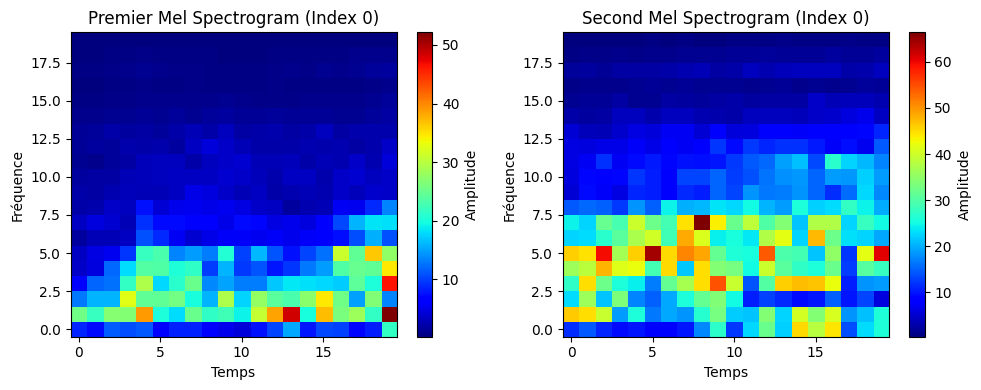

In [38]:
import matplotlib.pyplot as plt

# Charger les données modifiées pour la classe "chainsaw"
X_modifie_chainsaw = np.load(fm_dir + "feature_matrix_chainsaw_modified.npy")

# Afficher les melspectrogrammes pour chaque son de la classe "chainsaw"
for idx in range(0, 1, 2):  # Parcourir par paires (2 melspectrogrammes par son)
    plt.figure(figsize=(10, 4))

    # Premier melspectrogramme
    plt.subplot(1, 2, 1)
    plt.imshow(X_modifie_chainsaw[idx].reshape(20, 20), cmap="jet", aspect="auto")
    plt.colorbar(label="Amplitude")
    plt.title(f"Premier Mel Spectrogram (Index {idx // 2})")
    plt.xlabel("Temps")
    plt.ylabel("Fréquence")
    plt.gca().invert_yaxis()

    # Second melspectrogramme
    plt.subplot(1, 2, 2)
    plt.imshow(X_modifie_chainsaw[idx + 1].reshape(20, 20), cmap="jet", aspect="auto")
    plt.colorbar(label="Amplitude")
    plt.title(f"Second Mel Spectrogram (Index {idx // 2})")
    plt.xlabel("Temps")
    plt.ylabel("Fréquence")
    plt.gca().invert_yaxis()

    # Afficher les deux melspectrogrammes côte à côte
    plt.tight_layout()
    plt.show()

In [39]:
import numpy as np

# Charger les données
X = np.load(fm_dir + "feature_matrix_2D.npy")  # Matrice des caractéristiques
y = np.load(fm_dir + "labels_2D.npy")          # Étiquettes associées

# Classe concernée
classname = "fireworks"

# Initialiser la matrice pour stocker les melspectrogrammes modifiés
X_modifie_fireworks = []

# Filtrer les indices correspondant à la classe "fireworks"
indices_classe = np.where(y == classname)[0]

# Parcourir les indices de la classe "fireworks"
for idx, global_idx in enumerate(indices_classe):
    # Reshape pour transformer le vecteur 1D en une matrice 2D (temps x mels)
    melspectrogramme = X[global_idx].reshape(-1, 49)

    # --- Extraction du premier melspectrogramme ---
    # Toujours commencer à l'indice 3 et prendre les dimensions 3 à 23
    premier_melspectrogramme = melspectrogramme[:, 3:23]

    # --- Extraction du second melspectrogramme ---
    # Calculer les amplitudes moyennes pour les 20 dernières dimensions temporelles
    amplitudes_moyennes = [
        np.mean(melspectrogramme[:, start:start + 20]) for start in range(29, 49 - 20 + 1)
    ]
    # Trouver l'indice de départ qui maximise l'amplitude
    indice_depart_second = 29 + np.argmax(amplitudes_moyennes)
    second_melspectrogramme = melspectrogramme[:, indice_depart_second:indice_depart_second + 20]

    # Vérifier les amplitudes maximales
    max_amplitude_premier = np.max(premier_melspectrogramme)
    max_amplitude_second = np.max(second_melspectrogramme)

    # Ajouter uniquement si l'amplitude maximale est supérieure à 20
    if max_amplitude_premier > 31:
        X_modifie_fireworks.append(premier_melspectrogramme.flatten())
    if max_amplitude_second > 31:
        X_modifie_fireworks.append(second_melspectrogramme.flatten())

    # Debug : Afficher les informations pour chaque son
    print(f"Index: {idx}, "
          f"Max Amplitude Premier: {max_amplitude_premier}, "
          f"Max Amplitude Second: {max_amplitude_second}")

# Convertir la liste en un tableau numpy
X_modifie_fireworks = np.array(X_modifie_fireworks)
y_modifie_gun = np.array(["gun"] * X_modifie_gun.shape[0])
y_modifie_fireworks = np.array([classname] * X_modifie_fireworks.shape[0])
np.save(fm_dir + "labels_2D_fireworks_modified.npy", y_modifie_fireworks)
print(f"Shape of modified fireworks feature matrix: {X_modifie_fireworks.shape}")

# Sauvegarder la matrice modifiée pour la classe "fireworks"
np.save(fm_dir + "feature_matrix_fireworks_modified.npy", X_modifie_fireworks)

print("Extraction des melspectrogrammes pour la classe 'fireworks' terminée.")

Index: 0, Max Amplitude Premier: 71.4115407765948, Max Amplitude Second: 11.770119252748215
Index: 1, Max Amplitude Premier: 95.59085978142078, Max Amplitude Second: 26.55441126137476
Index: 2, Max Amplitude Premier: 103.13553354020776, Max Amplitude Second: 12.369799341745235
Index: 3, Max Amplitude Premier: 106.32636636956832, Max Amplitude Second: 9.239819150817873
Index: 4, Max Amplitude Premier: 43.37531313265011, Max Amplitude Second: 27.399787374007342
Index: 5, Max Amplitude Premier: 88.7564366683958, Max Amplitude Second: 14.882551401100663
Index: 6, Max Amplitude Premier: 108.59215046161117, Max Amplitude Second: 84.4962532745397
Index: 7, Max Amplitude Premier: 64.99484037797865, Max Amplitude Second: 66.70702153383517
Index: 8, Max Amplitude Premier: 102.54885243407708, Max Amplitude Second: 27.66377517839375
Index: 9, Max Amplitude Premier: 115.06522334766818, Max Amplitude Second: 27.376112313945907
Index: 10, Max Amplitude Premier: 80.72291300035938, Max Amplitude Second

In [40]:
import matplotlib.pyplot as plt

# Charger les données modifiées pour la classe "fireworks"
X_modifie_fireworks = np.load(fm_dir + "feature_matrix_fireworks_modified.npy")

# Afficher les melspectrogrammes pour chaque son de la classe "fireworks"
# for idx in range(0, X_modifie_fireworks.shape[0], 2):  # Parcourir par paires (2 melspectrogrammes par son)
#     plt.figure(figsize=(10, 4))

#     # Premier melspectrogramme
#     plt.subplot(1, 2, 1)
#     plt.imshow(X_modifie_fireworks[idx].reshape(20, 20), cmap="jet", aspect="auto")
#     plt.colorbar(label="Amplitude")
#     plt.title(f"Premier Mel Spectrogram (Index {idx // 2})")
#     plt.xlabel("Temps")
#     plt.ylabel("Fréquence")
#     plt.gca().invert_yaxis()

#     # Second melspectrogramme
#     plt.subplot(1, 2, 2)
#     plt.imshow(X_modifie_fireworks[idx + 1].reshape(20, 20), cmap="jet", aspect="auto")
#     plt.colorbar(label="Amplitude")
#     plt.title(f"Second Mel Spectrogram (Index {idx // 2})")
#     plt.xlabel("Temps")
#     plt.ylabel("Fréquence")
#     plt.gca().invert_yaxis()

#     # Afficher les deux melspectrogrammes côte à côte
#     plt.tight_layout()
#     plt.show()

In [41]:
import numpy as np

# Charger les données
X = np.load(fm_dir + "feature_matrix_2D.npy")  # Matrice des caractéristiques
y = np.load(fm_dir + "labels_2D.npy")          # Étiquettes associées

# Classe concernée
classname = "fire"

# Initialiser la matrice pour stocker les melspectrogrammes modifiés
X_modifie_fire = []

# Filtrer les indices correspondant à la classe "fire"
indices_classe = np.where(y == classname)[0]

# Parcourir les indices de la classe "fire"
for idx, global_idx in enumerate(indices_classe):
    # Reshape pour transformer le vecteur 1D en une matrice 2D (temps x mels)
    melspectrogramme = X[global_idx].reshape(-1, 49)

    # --- Extraction du premier melspectrogramme ---
    # Toujours commencer à l'indice 3 et prendre les dimensions 3 à 23
    premier_melspectrogramme = melspectrogramme[:, 3:23]

    # --- Extraction du second melspectrogramme ---
    # Calculer les amplitudes moyennes pour les 20 dernières dimensions temporelles
    amplitudes_moyennes = [
        np.mean(melspectrogramme[:, start:start + 20]) for start in range(29, 49 - 20 + 1)
    ]
    # Trouver l'indice de départ qui maximise l'amplitude
    indice_depart_second = 29 + np.argmax(amplitudes_moyennes)
    second_melspectrogramme = melspectrogramme[:, indice_depart_second:indice_depart_second + 20]

    # Vérifier les amplitudes maximales
    max_amplitude_premier = np.max(premier_melspectrogramme)
    max_amplitude_second = np.max(second_melspectrogramme)

    # Ajouter uniquement si l'amplitude maximale est supérieure à 20
    if max_amplitude_premier > 20:
        X_modifie_fire.append(premier_melspectrogramme.flatten())
    if max_amplitude_second > 20:
        X_modifie_fire.append(second_melspectrogramme.flatten())

    # Debug : Afficher les informations pour chaque son
    print(f"Index: {idx}, "
          f"Max Amplitude Premier: {max_amplitude_premier}, "
          f"Max Amplitude Second: {max_amplitude_second}")

# Convertir la liste en un tableau numpy
X_modifie_fire = np.array(X_modifie_fire)
y_modifie_gun = np.array(["gun"] * X_modifie_gun.shape[0])
y_modifie_fire = np.array([classname] * X_modifie_fire.shape[0])
np.save(fm_dir + "labels_2D_fire_modified.npy", y_modifie_fire)
# Sauvegarder la matrice modifiée pour la classe "fire"
np.save(fm_dir + "feature_matrix_fire_modified.npy", X_modifie_fire)


print("Extraction des melspectrogrammes pour la classe 'fire' terminée.")

Index: 0, Max Amplitude Premier: 39.44960092733001, Max Amplitude Second: 88.71728245257432
Index: 1, Max Amplitude Premier: 41.6441809996518, Max Amplitude Second: 51.16100197327252
Index: 2, Max Amplitude Premier: 23.584844920604244, Max Amplitude Second: 70.00662399377524
Index: 3, Max Amplitude Premier: 33.128802175542795, Max Amplitude Second: 65.75816167255547
Index: 4, Max Amplitude Premier: 122.5852475377166, Max Amplitude Second: 122.56009077211917
Index: 5, Max Amplitude Premier: 40.07630974594406, Max Amplitude Second: 84.51543930115051
Index: 6, Max Amplitude Premier: 82.86651649439662, Max Amplitude Second: 82.47901523787749
Index: 7, Max Amplitude Premier: 68.41313332547664, Max Amplitude Second: 55.80389841790066
Index: 8, Max Amplitude Premier: 55.14674366104005, Max Amplitude Second: 58.227701449301655
Index: 9, Max Amplitude Premier: 96.40438625203818, Max Amplitude Second: 91.82390268547412
Index: 10, Max Amplitude Premier: 44.273963071314505, Max Amplitude Second: 4

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Charger les données modifiées pour la classe "fire"
X_modifie_fire = np.load(fm_dir + "feature_matrix_fire_modified.npy")

# # Afficher les melspectrogrammes pour chaque son de la classe "fire"
# for idx in range(0, X_modifie_fire.shape[0], 2):  # Parcourir par paires (2 melspectrogrammes par son)
#     plt.figure(figsize=(10, 4))

#     # Premier melspectrogramme
#     plt.subplot(1, 2, 1)
#     plt.imshow(X_modifie_fire[idx].reshape(20, 20), cmap="jet", aspect="auto")
#     plt.colorbar(label="Amplitude")
#     plt.title(f"Premier Mel Spectrogram (Index {idx // 2})")
#     plt.xlabel("Temps")
#     plt.ylabel("Fréquence")
#     plt.gca().invert_yaxis()

#     # Second melspectrogramme
#     if idx + 1 < X_modifie_fire.shape[0]:  # Vérifier qu'il y a un second melspectrogramme
#         plt.subplot(1, 2, 2)
#         plt.imshow(X_modifie_fire[idx + 1].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Second Mel Spectrogram (Index {idx // 2})")
#         plt.xlabel("Temps")
#         plt.ylabel("Fréquence")
#         plt.gca().invert_yaxis()

#     # Afficher les deux melspectrogrammes côte à côte
#     plt.tight_layout()
#     plt.show()

In [43]:
import numpy as np

# Chemins des fichiers .npy pour chaque classe
chainsaw_file = fm_dir + "feature_matrix_chainsaw_modified.npy"
fire_file = fm_dir + "feature_matrix_fire_modified.npy"
fireworks_file = fm_dir + "feature_matrix_fireworks_modified.npy"
gun_file = fm_dir + "feature_matrix_2D_gun_modified.npy"

# Charger les matrices de caractéristiques pour chaque classe
X_chainsaw = np.load(chainsaw_file)
X_fire = np.load(fire_file)
X_fireworks = np.load(fireworks_file)
X_gun = np.load(gun_file)

# Assembler les matrices dans l'ordre spécifié
X = np.vstack([X_chainsaw, X_fire, X_fireworks, X_gun])

# Sauvegarder le dataset final
np.save(fm_dir + "feature_matrix_400.npy", X)
y = np.concatenate([
    np.array(["chainsaw"] * X_chainsaw.shape[0]),
    np.array(["fire"] * X_fire.shape[0]),
    np.array(["fireworks"] * X_fireworks.shape[0]),
    np.array(["gun"] * X_gun.shape[0])
])

np.save(fm_dir + "labels_400.npy", y)
print(f"Dataset assemblé et sauvegardé dans {fm_dir + 'feature_matrix_dataset.npy'}")
print(f"Forme du dataset final : {X.shape}")

Dataset assemblé et sauvegardé dans data/feature_matrices/feature_matrix_dataset.npy
Forme du dataset final : (466, 400)
